## Explainability of Attention Mechanisms in `t2` without Z Features and FC

This notebook looks at the attention responses for a given input and tries to explore the explainability of the attention mechanism that is being used in the `t2` model

In [1]:
import argparse
import joblib
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import shutil
import sys
import seaborn as sns
import tensorflow as tf

from itertools import cycle
from numpy import interp
from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from tensorflow import keras

from astronet.constants import astronet_working_directory as asnwd
from astronet.preprocess import one_hot_encode
from astronet.utils import astronet_logger, load_dataset, find_optimal_batch_size

In [2]:
from astronet.metrics import WeightedLogLoss
from astronet.visualise_results import plot_acc_history, plot_confusion_matrix, plot_loss_history, plot_multiROC

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

import random as python_random
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(RANDOM_SEED)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"]})

plt.rcParams["figure.figsize"] = (20,3)

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [4]:
mpl.style.use("seaborn-whitegrid")

In [5]:
architecture = "t2"

In [6]:
dataset = "plasticc"

In [10]:
X_train, y_train, X_test, y_test, loss = load_dataset(dataset)

In [11]:
num_classes = y_train.shape[1]
num_classes

3

In [12]:
BATCH_SIZE = find_optimal_batch_size(X_train.shape[0])
_, timesteps, num_features = X_train.shape  # X_train.shape[1:] == (TIMESTEPS, num_features)
input_shape = (BATCH_SIZE, timesteps, num_features)
input_shape

(16, 100, 6)

Get params for best model with lowest loss. Once we have the associated parameters, the corresponding model will be instanciated.

In [14]:
# with open(f"{asnwd}/astronet/{architecture}/models/{dataset}/results.json") as f:
#     events = json.load(f)
#     # Get params for best model with lowest loss
#     event = min(events['training_result'], key=lambda ev: ev['loss'])
    
model_name = "1612541563-63c7b2d"

# model_name = "1612366652-64d2e26"

with open(f"{asnwd}/astronet/{architecture}/models/{dataset}/results.json") as f:
    events = json.load(f)
    if model_name is not None:
    # Get params for model chosen with cli args
        event = next(item for item in events['training_result'] if item["name"] == model_name)
    else:
        # Get params for best model with lowest loss
        event = min(
            (item for item in events["training_result"] if item["augmented"] is None),
                key=lambda ev: ev["model_evaluate_on_test_loss"],
            )

#         event = min(events['training_result'], key=lambda ev: ev['model_evaluate_on_test_loss'])

In [15]:
# Show short summary of items in 'event'
dict(list(event.items())[1:4])

{'augmented': None, 'droprate': 0.1, 'embed_dim': 32}

In [16]:
model_name = event['name']

In [17]:
model_name

'1612541563-63c7b2d'

In [18]:
# model = keras.models.load_model(f"{asnwd}/astronet/{architecture}/models/{dataset}/model-{model_name}", 
#                                 custom_objects={'WeightedLogLoss': WeightedLogLoss()}, 
#                                compile=False)

In [19]:
embed_dim = event['embed_dim']  # --> Embedding size for each token
num_heads = event['num_heads']  # --> Number of attention heads
ff_dim = event['ff_dim']  # --> Hidden layer size in feed forward network inside transformer

# --> Number of filters to use in ConvEmbedding block, should be equal to embed_dim
num_filters = embed_dim

num_layers = event['num_layers']    # --> N x repeated transformer blocks
droprate = event['droprate']        # --> Rate of neurons to drop
fc_neurons = event['fc_neurons']    # --> N neurons in final Feed forward network.

In [20]:
from astronet.t2.model import T2Model

In [24]:
from keras.models import Model

# _, num_z_features = Z_train.shape
# Z_input_shape = (BATCH_SIZE, num_z_features)

# input_shape_nobatch = input_shape[1:]
# Z_input_shape_nobatch = Z_input_shape[1:]

# inputs = [
#     tf.keras.Input(shape=input_shape_nobatch), 
#     tf.keras.Input(shape=Z_input_shape_nobatch),
# ]
inputs = tf.keras.Input(shape=input_shape_nobatch)
input_shape_nobatch = input_shape[1:]

In [25]:
# input_shape_nobatch, Z_input_shape_nobatch
input_shape_nobatch

(100, 6)

In [26]:
inputs

<KerasTensor: shape=(None, 100, 6) dtype=float32 (created by layer 'input_1')>

In [27]:
tf.config.run_functions_eagerly(True)

Instanciate a `T2Model` and load with parameters defined earlier from saved configuration file

In [28]:
model = T2Model(        
    input_dim=input_shape,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_filters=num_filters,
    num_classes=num_classes,
    num_layers=num_layers,
    droprate=droprate,
    fc_neurons=fc_neurons,
)

In [29]:
model.call(inputs, training=True)

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_6')>

In [31]:
model.build(input_shape)

In [32]:
# model.load_weights(f"{asnwd}/astronet/{architecture}/models/{dataset}/weights-1611674535-affdd40")
# model.load_weights(f"{asnwd}/astronet/{architecture}/models/{dataset}/weights-{model_name}")
model.load_weights(f"{asnwd}/astronet/{architecture}/models/{dataset}/model-{model_name}")

In [33]:
model.summary()

Model: "t2_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_embedding (ConvEmbeddin (None, 100, 32)           224       
_________________________________________________________________
positional_encoding (Positio (None, 100, 32)           0         
_________________________________________________________________
transformer_block (Transform (None, 100, 32)           12704     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 99 

In [34]:
model.layers

In [35]:
for i in model.layers:
    print(i.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 32), dtype=tf.float32, name=None), name='conv_embedding/conv1d/Relu:0', description="created by layer 'conv_embedding'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 32), dtype=tf.float32, name=None), name='positional_encoding/add:0', description="created by layer 'positional_encoding'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 32), dtype=tf.float32, name=None), name='transformer_block/layer_normalization_1/batchnorm/add_1:0', description="created by layer 'transformer_block'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='global_average_pooling1d/Mean:0', description="created by layer 'global_average_pooling1d'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='dropout_2/dropout/Mul_1:0', description="created by layer 'dropout_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='dropout_3/dropout/Mul_1:

### Explainability of Attention Mechanisms

1. Choose random sample from test set

In [179]:
# rindex = np.random.choice(len(X_test), 1)
rindex = np.array([466])  # 102 is a nice looking Type Ia
print(rindex)

[466]


In [180]:
x = X_test[rindex]
x.shape

(1, 100, 6)

In [181]:
z = Z_test[rindex]
z

array([[1.14, 0.03]])

In [182]:
from astronet.visualise_results import _get_encoding

What does this random sample look like?

In [183]:
max(x[0].flatten())

1.8426679694012893

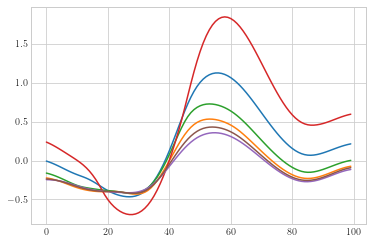

In [184]:
encoding, class_encoding, class_names = _get_encoding(dataset)

y_true = encoding.inverse_transform(y_test[rindex])
# print(np.argmax(y_true))
# print(class_names[np.argmax(y_true)])
plt.figure(figsize=(6, 4))
plt.plot(x[0])

In [185]:
# x = np.expand_dims(x, axis=0)
# x.shape

From our random sample, we have chosen a class of:

In [186]:
print(class_names[np.argmax(y_test[rindex])])

SNIa


In [187]:
model.predict(x)

/usr/local/anaconda3/envs/astronet/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


array([[0.35, 0.05, 0.60]], dtype=float32)

2. Get output from Transformer Block

In [188]:
layer_name = "transformer_block"
model.get_layer(layer_name).output

<KerasTensor: shape=(None, 100, 32) dtype=float32 (created by layer 'transformer_block')>

In [189]:
# predictions = tf.keras.layers.Dense(152, activation='softmax')(model.layers[-3].output)

3. Instantiate a new "Attention" model, whose output will be a vector representaiton of the weights coming from the Transformer block.

In [190]:
attmodel = Model(inputs=inputs, outputs=model.get_layer(layer_name).output)
# annmodel.compile(optimizer='adam', loss=WeightedLogLoss)

4. Get vector representation from our random sampled input from the test set

In [191]:
vector = attmodel.predict(x)
vector.shape, vector

((1, 100, 32),
 array([[[-0.10, 0.10, 0.05, ..., 0.03, -0.02, 0.03],
         [-0.02, 0.21, 0.08, ..., 0.11, -0.02, 0.11],
         [-0.08, 0.10, 0.07, ..., -0.06, -0.02, 0.03],
         ...,
         [-0.28, 0.23, -0.33, ..., -0.01, -0.03, -0.05],
         [-0.24, 0.28, -0.33, ..., 0.02, -0.03, -0.02],
         [-0.34, -0.15, -0.13, ..., -0.19, -0.02, -0.19]]], dtype=float32))

* Rearrange axis for easier visualisation

In [192]:
v = np.moveaxis(vector, 1, 2)
v.shape, vector.shape

((1, 32, 100), (1, 100, 32))

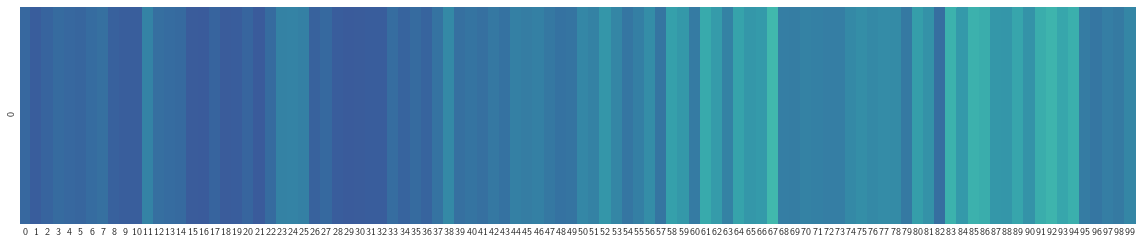

In [193]:
import seaborn as sns
cmap = sns.cm.mako
%matplotlib inline
# f, axes = plt.subplots(2, 1)
# ax = plt.plot(x[0], ax=axes.flat[0])
# ax2 = ax.twinx()
plt.figure(figsize=(20, 4))
sns.heatmap(np.abs([v[0][0]]), cmap=cmap, cbar=False, vmin=v.min(), vmax=v.max())
plt.show()

In [194]:
plt.figure(figsize=(20, 10))
# plt.plot(x[0])

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

* Note that darker reigons do not nessearily indicate low 'power' since the weights can range in magnitute from 'high' negative values to 'high' positive values

In [195]:
cmap = sns.cm.rocket
cmap = sns.light_palette("Navy", as_cmap=True)
cmap = sns.color_palette("Spectral", as_cmap=True)
cmap = sns.color_palette("viridis", as_cmap=True)
cmap = sns.color_palette("magma", as_cmap=True)
my_cmap = sns.light_palette("Navy", as_cmap=True)

N=100
colors = np.linspace(0,1,N)

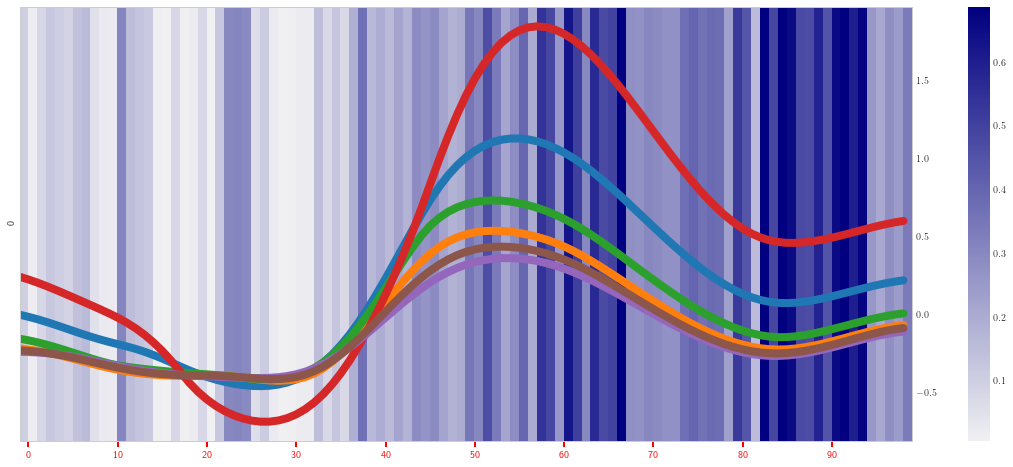

In [197]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.heatmap(np.abs([v[0][0]]), cmap=my_cmap, cbar=True, robust=True, ax=ax) # vmin=v.min(), vmax=v.max()
ax2 = ax.twinx()
ax2.plot(x[0], lw=8)
ax2.grid(False)

ax.xaxis.set_ticks(np.arange(1, 100, 10))
ax.set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ax.tick_params(axis='x', direction='out', length=6, width=2, colors='r',
               grid_color='r', grid_alpha=0.5)
# ax.set_ylim([min(x[0].flatten()),max(x[0].flatten()) + 1])
# ax.set_xlim(0, 99)

In [162]:
# final transformer layer
print(model.layers[-4].name)

# global average pooling layer
print(model.layers[-5].name)

# output of the classifier
print(model.layers[-1].name)

global_average_pooling1d
transformer_block
dense_6


In [163]:
# same as previous model but with an additional output
cam_model  = Model(inputs=inputs,outputs=(model.layers[-5].output,model.layers[-1].output))
cam_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 6)]          0         
_________________________________________________________________
conv_embedding (ConvEmbeddin (None, 100, 32)           224       
_________________________________________________________________
positional_encoding (Positio (None, 100, 32)           0         
_________________________________________________________________
transformer_block (Transform (None, 100, 32)           12704     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0   

In [164]:
# get the features and results of the test images using the newly created model
features,results = cam_model.predict(X_test)

# shape of the features
print("features shape: ", features.shape)
print("results shape", results.shape)

/usr/local/anaconda3/envs/astronet/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


features shape:  (998, 100, 32)
results shape (998, 3)


In [165]:
model.layers[-4].name

'global_average_pooling1d'

In [166]:
# these are the weights going into the softmax layer
last_dense_layer = model.layers[-1]

# get the weights list.  index 0 contains the weights, index 1 contains the biases
gap_weights_l = last_dense_layer.get_weights()

print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

# shows the number of features per class, and the total number of classes
# Store the weights
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

gap_weights_l index 0 contains weights  (32, 3)
gap_weights_l index 1 contains biases  (3,)
There are 32 feature weights and 3 classes.


In [252]:
features.shape

(998, 100, 32)

In [167]:
# Get the features for the image at index 0
idx = 0
features_for_img = features[idx,:,:]

print(f"The features for image index {idx} has shape (timesteps, num of feature channels) : ", features_for_img.shape)

The features for image index 0 has shape (timesteps, num of feature channels) :  (100, 32)


In [168]:
# Select the weights that are used for a specific class (0...9)
class_id = 0
# take the dot product between the scaled image features and the weights for 
gap_weights_for_one_class = gap_weights[:,class_id]

print("features_for_img_scaled has shape ", features_for_img.shape)
print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)
# take the dot product between the scaled features and the weights for one class
cam = np.dot(features_for_img, gap_weights_for_one_class)

print("class activation map shape ", cam.shape)

features_for_img_scaled has shape  (100, 32)
gap_weights_for_one_class has shape  (32,)
class activation map shape  (100,)


In [169]:
import matplotlib.pyplot as plt 

In [248]:
def show_cam(image_index):
    '''displays the class activation map of a particular image'''

  # takes the features of the chosen image
    features_for_img = features[image_index,:,:]

  # get the class with the highest output probability
    prediction = np.argmax(results[image_index])

  # get the gap weights at the predicted class
    class_activation_weights = gap_weights[:,prediction]

  # upsample the features to the image's original size (28 x 28)
#   class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)
    class_activation_features = features_for_img

  # compute the intensity of each feature in the CAM
    cam_output = np.dot(class_activation_features,class_activation_weights)
    print(cam_output.shape)
    print(np.expand_dims(cam_output, axis=0).shape)
    cam_output = np.expand_dims(cam_output, axis=0)
    print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(results[image_index][prediction]))
  
  # show the upsampled image
#     fig, ax = plt.subplots(figsize=(20, 8))
#     ax.plot(X_test[image_index])
  
  # strongly classified (95% probability) images will be in green, else red
#     if results[image_index][prediction]>0.95:
#         cmap_str = 'Greens'
#     else:
#         cmap_str = 'Reds'

  # overlay the cam output
#     plt.plot(cam_output, cmap=cmap_str, alpha=0.5)
#     ax2 = ax.twinx()
#     sns.heatmap(cam_output, cmap=my_cmap, cbar=False, robust=True, ax=ax2) # vmin=v.min(), vmax=v.max()

#     ax2.plot(x[0], lw=8)
#     ax2.grid(False)

#     ax.xaxis.set_ticks(np.arange(1, 100, 10))
#     ax.set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
#     ax.tick_params(axis='x', direction='out', length=6, width=2, colors='r',grid_color='r', grid_alpha=0.5)
    
    fig, ax = plt.subplots(figsize=(20, 8))
    from scipy.special import softmax
    sns.heatmap(softmax(cam_output), cmap=my_cmap, cbar=True, robust=True, ax=ax) # vmin=v.min(), vmax=v.max()
    ax2 = ax.twinx()
    ax2.plot(X_test[image_index], lw=5)
    ax2.grid(False)

    ax.xaxis.set_ticks(np.arange(1, 100, 10))
    ax.set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
    ax.tick_params(axis='x', direction='out', length=6, width=2, colors='r',
               grid_color='r', grid_alpha=0.5)

  # display the image
    plt.show()
    plt.clf()

In [249]:
np.argmax(results[435])

2

In [250]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates CAMs 
    for the first `num_maps`(int) of the `desired_class`(int)
    '''

    counter = 0

    if desired_class > 10:
        print("please choose a class less than 10")

    # go through the first 10000 images
    for i in range(0,10):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i)

(100,)
(1, 100)
Predicted Class = 2, Probability = 0.6388067


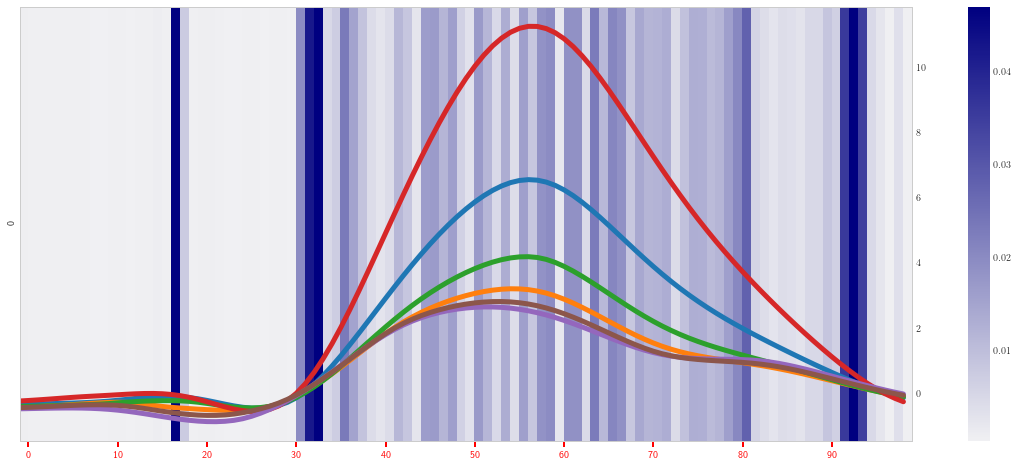

(100,)
(1, 100)
Predicted Class = 2, Probability = 0.9638417


<Figure size 432x288 with 0 Axes>

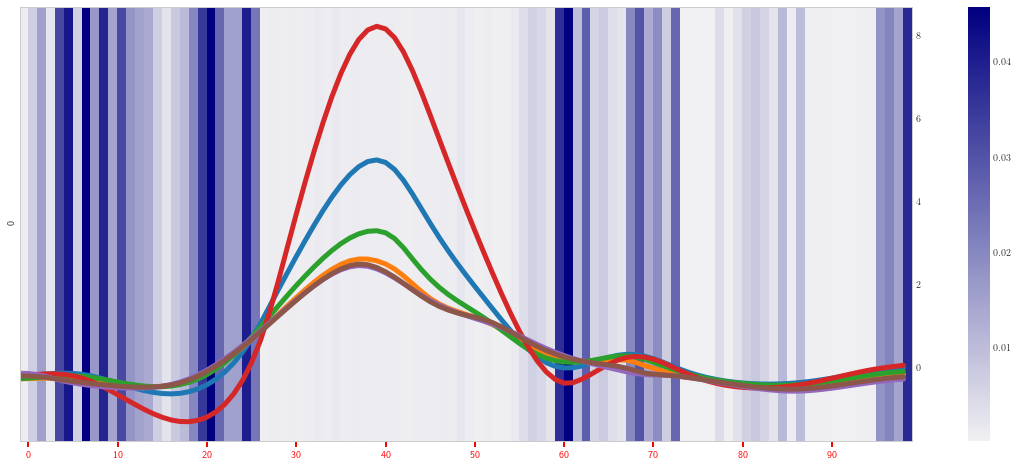

(100,)
(1, 100)
Predicted Class = 2, Probability = 0.9484252


<Figure size 432x288 with 0 Axes>

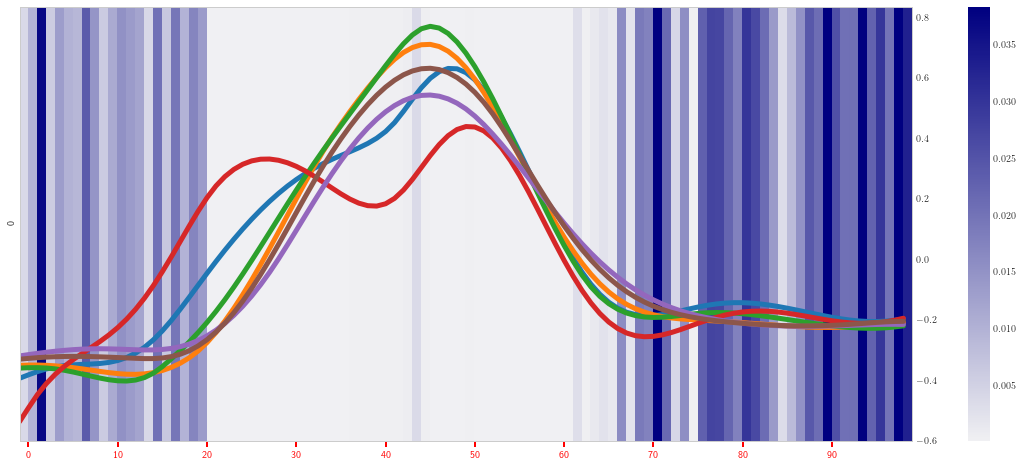

<Figure size 432x288 with 0 Axes>

In [251]:
show_maps(desired_class=2, num_maps=3)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

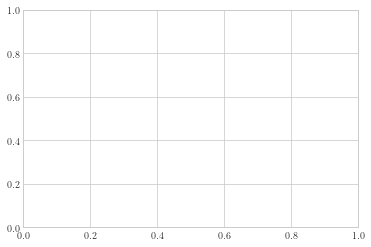

In [138]:
axes = plt.gca()


In [ ]:
axes

In [ ]:
fig = plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1, sharey = ax1)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

# function to be learned
def f(x):
    return x[0] + x[1] + x[2]

# sample training and test points on a rectangular grid
x_train = np.random.uniform(low = -10, high = 10, size = (5000,3))
y_train = np.apply_along_axis(f, 1, x_train).reshape(-1,1)

x_test = np.random.uniform(low = -10, high = 10, size = (5000,3))
y_test = np.apply_along_axis(f, 1, x_test).reshape(-1,1)

model = Sequential()
model.add(Dense(20, input_dim = 3, activation = 'tanh'))
model.add(Dense(1))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse',
      optimizer=sgd)
model.fit(x_train, y_train, batch_size = 10, epochs = 30, verbose = 0)

model.evaluate(x_test, y_test, batch_size = 10)
model.evaluate(x_test, y_test, batch_size = 20)
model.evaluate(x_test, y_test, batch_size = 30)
model.evaluate(x_test, y_test, batch_size = 40)
model.evaluate(x_test, y_test, batch_size = 50)

In [ ]:
x_test.shape

In [ ]:
from sklearn.metrics import mean_squared_error as mse
0 == model.evaluate(x_test, y_test) - mse(model.predict(x_test), y_test)

In [ ]:
model.evaluate(x_test, y_test, batch_size=x_test.shape[0])

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
mse(model.predict(x_test, batch_size=x_test.shape[0]), y_test)